In [1]:
import zipfile
from subprocess import call

import psutil

import pandas as pd
import numpy as np
import json
import datetime

import os
import cPickle as pickle
from multiprocessing import Pool

import geopy
import geopandas as gpd
import shapely.geometry as geom

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [99]:
pd.options.display.max_columns = 55

### AQUIRE DATA WITH WGET AND ZIPFILE

In [2]:
base_url = "https://s3.amazonaws.com/tripdata/"
for d in range(201501,201513):
    url = base_url + str(d) + '-citibike-tripdata.zip'
    print(url)
    call(['wget',url])
    zfile = zipfile.ZipFile(str(d)+'-citibike-tripdata.zip', 'r' )
    zfile.extractall('unzippedData/')
    zfile.close()

https://s3.amazonaws.com/tripdata/201501-citibike-tripdata.zip
https://s3.amazonaws.com/tripdata/201502-citibike-tripdata.zip
https://s3.amazonaws.com/tripdata/201503-citibike-tripdata.zip
https://s3.amazonaws.com/tripdata/201504-citibike-tripdata.zip
https://s3.amazonaws.com/tripdata/201505-citibike-tripdata.zip
https://s3.amazonaws.com/tripdata/201506-citibike-tripdata.zip
https://s3.amazonaws.com/tripdata/201507-citibike-tripdata.zip
https://s3.amazonaws.com/tripdata/201508-citibike-tripdata.zip
https://s3.amazonaws.com/tripdata/201509-citibike-tripdata.zip
https://s3.amazonaws.com/tripdata/201510-citibike-tripdata.zip
https://s3.amazonaws.com/tripdata/201511-citibike-tripdata.zip
https://s3.amazonaws.com/tripdata/201512-citibike-tripdata.zip


In [57]:
# LOAD INTO PANDAS
dfs = []
for f in os.listdir('unzippedData/'):
    dfs.append(pd.read_csv('unzippedData/'+f))
    
full_df = pd.concat(dfs, ignore_index=True)

In [58]:
print(full_df.shape)

print(full_df.columns)

full_df.head(8)

(9937969, 15)
Index([u'tripduration', u'starttime', u'stoptime', u'start station id',
       u'start station name', u'start station latitude',
       u'start station longitude', u'end station id', u'end station name',
       u'end station latitude', u'end station longitude', u'bikeid',
       u'usertype', u'birth year', u'gender'],
      dtype='object')


,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,1346,1/1/2015 0:01,1/1/2015 0:24,455,1 Ave & E 44 St,40.750020,-73.969053,265,Stanton St & Chrystie St,40.722293,-73.991475,18660,Subscriber,1960.0,2
1,363,1/1/2015 0:02,1/1/2015 0:08,434,9 Ave & W 18 St,40.743174,-74.003664,482,W 15 St & 7 Ave,40.739355,-73.999318,16085,Subscriber,1963.0,1
2,346,1/1/2015 0:04,1/1/2015 0:10,491,E 24 St & Park Ave S,40.740964,-73.986022,505,6 Ave & W 33 St,40.749013,-73.988484,20845,Subscriber,1974.0,1
3,182,1/1/2015 0:04,1/1/2015 0:07,384,Fulton St & Waverly Ave,40.683178,-73.965964,399,Lafayette Ave & St James Pl,40.688515,-73.964763,19610,Subscriber,1969.0,1
4,969,1/1/2015 0:05,1/1/2015 0:21,474,5 Ave & E 29 St,40.745168,-73.986831,432,E 7 St & Avenue A,40.726218,-73.983799,20197,Subscriber,1977.0,1
5,496,1/1/2015 0:07,1/1/2015 0:15,512,W 29 St & 9 Ave,40.750073,-73.998393,383,Greenwich Ave & Charles St,40.735238,-74.000271,20788,Subscriber,1969.0,2
6,152,1/1/2015 0:07,1/1/2015 0:09,498,Broadway & W 32 St,40.748549,-73.988084,474,5 Ave & E 29 St,40.745168,-73.986831,19006,Subscriber,1972.0,1
7,1183,1/1/2015 0:08,1/1/2015 0:28,405,Washington St & Gansevoort St,40.739323,-74.008119,174,E 25 St & 1 Ave,40.738177,-73.977387,17640,Subscriber,1985.0,2


 ### 1) HOW MANY DATA POINTS ARE THERE IN 2015


In [4]:
total_rides = len(full_df)
print(total_rides)

9937969


### 2) EVALUATE TRIP DURATIONS

Lets clean a little first:

In [6]:
# Get rid of rides that are too long
# Citibike is designed for 30 min rides and charges $4 for every 15 min past that.

# only 1% of rides are longer than an hour so we can get rid of them
long_rides = len(full_df.loc[full_df.tripduration > 3600, 'tripduration'])
print(float(long_rides)/len(full_df))


0.01324928665


In [7]:
full_df.drop(full_df[full_df.tripduration>3600].index, inplace = True)
assert len(full_df) == total_rides - long_rides

In [8]:
# Get rid of cancelled rides
# I'm assuming that rides that are under 2 minutes and start and stop at the same station are essentially cancellations.

cancelled = full_df.loc[(full_df.tripduration<120) & (full_df['start station id'] == full_df['end station id'])]
print('Number of Cancelled Rides:', cancelled.shape[0])

('Number of Cancelled Rides:', 29345)


In [9]:
full_df.drop(cancelled.index, inplace = True)

assert len(full_df) == total_rides - long_rides - len(cancelled)

In [10]:
# NAs

# birth Year has 1.2 million nulls
# we will come back to that as the rest looks pretty good.
full_df.isnull().sum() 

tripduration                     0
starttime                        0
stoptime                         0
start station id                 0
start station name               0
start station latitude           0
start station longitude          0
end station id                   0
end station name                 0
end station latitude             0
end station longitude            0
bikeid                           0
usertype                         0
birth year                 1210701
gender                           0
dtype: int64

Plot Trip Durations

The data is too large for my puny macbook air so i'm going to use a sample of it

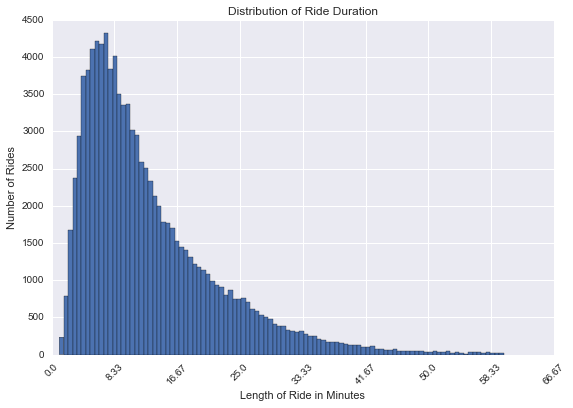

In [11]:
samp = full_df.sample(100000)

plt.figure(figsize=(9,6))
y, x, patches = plt.hist(samp.tripduration, bins = 100)

# get center of bins rather than edges
x = (x[1:] + x[:-1])/2
# normalize y
y = y/y.sum()


ax = plt.gca()
ax.set_xticklabels(np.round(plt.xticks()[0]/60, 2), rotation = 45)
plt.xlabel('Length of Ride in Minutes')
plt.ylabel('Number of Rides')
plt.title('Distribution of Ride Duration')

# BULK OF PEOPLE PROBABLY JUST RIDE TO WORK OR TO FROM NEARBY LOCATION
# AS IS THE DESIGNED USE FOR CITIBIKE

Fit to a Distribution

In [45]:
# Find a Distribution
from scipy.stats import pareto, logistic, lognorm, betaprime, beta, f, expon, norm

'''
The process involves fitting a distribution to the sample data
calculating the histogram (true distribution)
calculating the pdf of the fitted theoretical distribution
calculating the mean square error

''';

In [49]:
# use x an y from previous histogram

param_dic = {}
pdf_df = pd.DataFrame({'x':x, 'y':y})

for dist in [betaprime, beta, f]:
    #fit distribution to our data
    params = dist.fit(samp.tripduration) # this returns (*shapes, location, scale) 
                                # can be multiple shape parameters
    
    # pdf takes (x_values, *shape_params, location, scale)
    pdf = dist.pdf(x, *params[:-2], loc = params[-2], scale = params[-1])

    
    # store the parameters and pdf results
    param_dic[dist.name] = params
    pdf_df[dist.name] = pdf

In [64]:
cols = [c for c in pdf_df if c not in ('x','y')]
# calculate Sum of Squared Errors
sse = pdf_df[cols].sub(pdf_df.y, axis = 0).pow(2).sum()

sse.sort_values()

betaprime    0.024470
f            0.024471
beta         0.024518
dtype: float64

('betaprime', 'firebrick')
('beta', 'limegreen')
('f', 'coral')


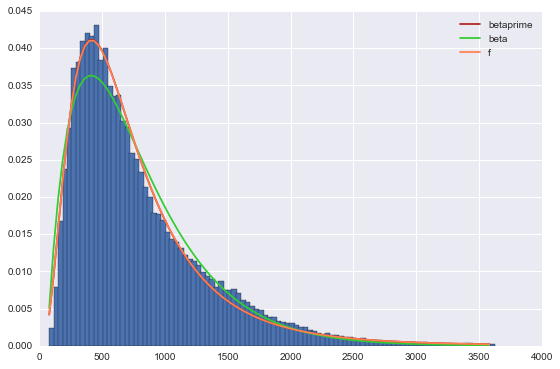

In [69]:
plt.figure(figsize = (9,6))
plt.bar(x,y, width = 44);

colors = ['firebrick','limegreen','coral', (115/255., 44/255., 123/255.)]
c = 0



for col in cols:
    print(col,colors[c])
    norm = y.sum()/pdf_df[col].sum()
    plt.plot(x,pdf_df[col].values*norm, color = colors[c], label = col)
    c+=1

plt.legend()

### 3) Make a plot of the total number of trips per hour of the day.

In [70]:
samp = full_df.sample(100000)
print(samp.shape)
samp['starttime'] = pd.to_datetime(samp.starttime)
samp['stoptime'] = pd.to_datetime(samp.stoptime)

(100000, 15)


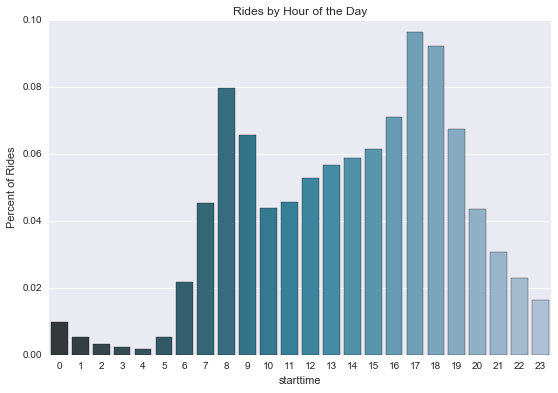

In [71]:
# Group by Hour and Plot
byhour = samp.groupby(samp.starttime.dt.hour)
sns.barplot(byhour.size().index, byhour.size()/byhour.size().sum(), palette = 'PuBuGn_d')
fig =plt.gcf()
fig.set_figheight(6)
fig.set_figwidth(9)
plt.ylabel('Percent of Rides')
plt.title('Rides by Hour of the Day')

# Most people ride to and from work - morning and eve rush hour (8-9am, 5-6pm)

Examine Weekdays Vs Weekends

In [72]:
# MONDAY = 0, SUNDAY = 6
weekdays = samp[samp.starttime.dt.dayofweek < 5]
weekends = samp[samp.starttime.dt.dayofweek >= 5]


print weekdays.shape[0], weekends.shape[0]

76900 23100


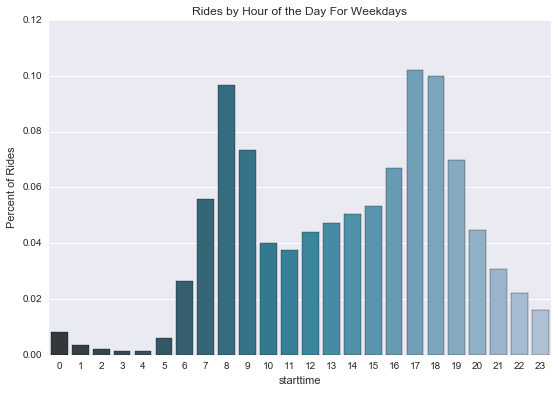

In [73]:
# WEEKDAYS
wdayByHour = weekdays.groupby(weekdays.starttime.dt.hour)
sns.barplot(wdayByHour.size().index, wdayByHour.size()/wdayByHour.size().sum(), palette = 'PuBuGn_d')
fig =plt.gcf()
fig.set_figheight(6)
fig.set_figwidth(9)
plt.ylabel('Percent of Rides')
plt.title('Rides by Hour of the Day For Weekdays')

# The trend is exaggerated for weekdays 

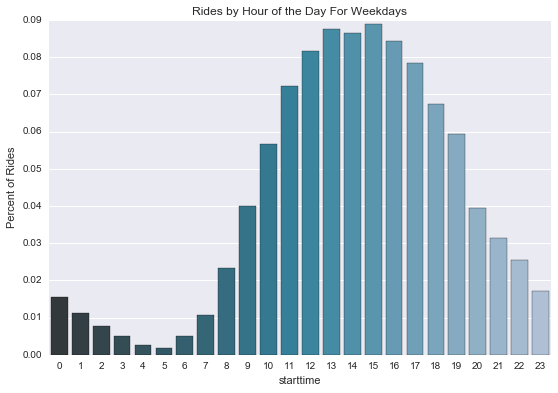

In [74]:
# WEEKENDS
wdayByHour = weekends.groupby(weekends.starttime.dt.hour)
sns.barplot(wdayByHour.size().index, wdayByHour.size()/wdayByHour.size().sum(), palette = 'PuBuGn_d')
fig =plt.gcf()
fig.set_figheight(6)
fig.set_figwidth(9)
plt.ylabel('Percent of Rides')
plt.title('Rides by Hour of the Day For Weekdays')

# And inverse for weekends

### 4) Mismatched end-->start locations

There are instances where a bike's next trip originates from a different station than it was returned to for its most recent previous trip. What do you think causes this?


In [122]:
# converting to datetime objects takes far too long so i'm going to use
# 3 months of data as a sample

# samples can't be random since they would lose the mismatch information if they were
# eg most bikes would start in different locations than they "previously" ended

months = full_df.starttime.str.findall(r'(\d+)/\d+/\d+\s')
months= months.map(lambda l: l[0])

month_ixs = months[months.isin(['1','5','9'])].index

samp = full_df.ix[month_ixs] 
samp['starttime'] = pd.to_datetime(samp.starttime)
samp['stoptime'] = pd.to_datetime(samp.stoptime)

In [123]:
# save to pickle so I don't have to convert dates again
with open('sampleMonths.pkl', 'wb') as f:
    pickle.dump(samp, f, 2)

In [2]:
# Load from pickle
with open('sampleMonths.pkl', 'rb') as f:
    samp = pickle.load(f)

In [3]:
# (2491402, 15)
samp.shape

(2491402, 15)

In [4]:
# groupby bikeid and sort by time to get sequential rides on each bike
bybike = samp.groupby('bikeid').apply(lambda v: v.sort_values('starttime')).drop('bikeid',axis =1).reset_index(0)

#shift bikeid, end station, and end_times for sequential comparisons
bybike['prev_bikeid'] = bybike.bikeid.shift(1)
# prevent overlapping ids
bybike.loc[bybike.prev_bikeid != bybike.bikeid, 'prev_bikeid'] = np.nan
# same for end station
bybike['prev_end_station_id'] = bybike['end station id'].shift(1)
bybike.loc[bybike.prev_bikeid.isnull(), 'prev_end_station_id'] = np.nan

# same for stoptime
bybike['prev_stoptime'] = bybike.stoptime.shift(1)
bybike.loc[bybike.prev_bikeid.isnull(), 'prev_stoptime'] = np.nan




In [5]:
# now select rows where prev_end_station does not equal start station

mismatch = bybike[(bybike.prev_end_station_id != bybike['start station id']) & (~bybike.prev_bikeid.isnull())]

# about 8% are mismatches
mismatch.shape

(177780, 18)

Explore the Mismatches

Avg Num Mismatches per Bike: 21.6857770188


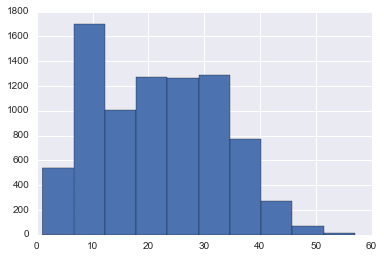

In [6]:
print 'Avg Num Mismatches per Bike:', mismatch.groupby('bikeid').size().mean()

mismatch.groupby('bikeid').size().hist()

Mismatches by day of the week and time of day


In [7]:

# MONDAY = 0, SUNDAY = 6
weekdays = mismatch[mismatch.starttime.dt.dayofweek < 5]
weekends = mismatch[mismatch.starttime.dt.dayofweek >= 5]

# ~80% happen during the week implying slight bias to the weekdays. EG 4:1 instead of 5:2
print "Percent of reappearances that happen on a weekday:", np.round(weekdays.shape[0]/float(len(mismatch)),2)


Percent of reappearances that happen on a weekday: 0.79


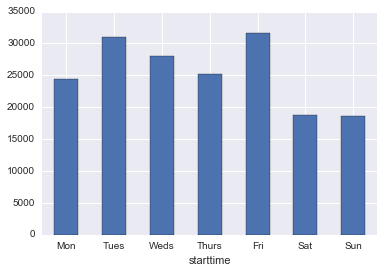

In [8]:
# Confirmed by looking at mismatches by DOW
# No serious bias for a given day
ax = mismatch.groupby(mismatch.starttime.dt.dayofweek).size().plot(kind='bar')
ax.set_xticklabels(['Mon','Tues','Weds','Thurs','Fri','Sat','Sun'], rotation = 0)

In [9]:
# Look at difference in start time and previous end time for mismatches
mismatch['time_diff'] = mismatch.starttime - mismatch.prev_stoptime

/Users/RickS/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [10]:
# Average time between mismatches
print 'Avg bike-disappearance time:',mismatch.time_diff.mean()
# Median time between mismatches
print 'Median bike-disappearance time:',mismatch.time_diff.median()

# I'm taking the median because the mean is dragged up by some very heavy outliers
print
print "Largest time gaps between bike reappearance:"
mismatch.time_diff.nlargest(10)

Avg bike-disappearance time: 5 days 23:53:43.755011
Median bike-disappearance time: 0 days 10:13:49

Largest time gaps between bike reappearance:


6625451   262 days 23:30:23
5654148   242 days 13:52:24
6847267   241 days 12:46:10
5658204   239 days 23:30:12
6048590   239 days 04:58:27
5647493   238 days 23:05:28
5647199   238 days 20:18:45
6480421   238 days 20:12:58
6616098   236 days 14:28:20
5647872   234 days 22:29:46
Name: time_diff, dtype: timedelta64[ns]

In [11]:
# Compare our station-mismatched bikes to the rest of the bikes 
# we see that normally functioning bikes are generally inactive for a much shorter period of time


normal = bybike[~bybike.index.isin(mismatch.index)]
print normal.shape
assert normal.shape[0] + mismatch.shape[0] == bybike.shape[0]
# The average inactivity for normal functioning bikes is about 3 hours
print 'Avg time inactive:',(normal.starttime - normal.prev_stoptime).mean()


# However this is being dragged up by some outliers as well and the median time is actually significantly lower still.
print 'Median time inactive:',(normal.starttime - normal.prev_stoptime).median()


(2313622, 18)
Avg time inactive: 0 days 03:04:56.917613
Median time inactive: 0 days 00:30:47


My conclusion on the matter is that bikes that stop at one station and then "mysteriously" appear at another station are most likely being worked on. The median time a bike is generally inactive for is about 30 minutes, which is much shorter than the median time of 10 hours for bikes that start at a different staion than they last ended. 

### 5) Build A Model

What makes people want to go ride a bike?
    - Work nearby
        o Density of Office Buildings 
        o Proximity to Residential 
    - Weather
    - Season (Tourism)
    - Train Delays
    - Healthy People
    - Education Level
    - Income Level

Before we build a model, lets explore the data a little more

For Example: What are the busiest stations of the year?

In [21]:
# Map station ids to name
stnID_name = samp[['start station id', 'start station name']].drop_duplicates('start station id').sort_values('start station id')
stnID_name.set_index('start station id', inplace=True)

# MOST USED STATIONS
stnID_name.ix[samp.groupby('start station id').size().nlargest(10).index]

,start station name
start station id,
521,8 Ave & W 31 St
519,Pershing Square North
293,Lafayette St & E 8 St
435,W 21 St & 6 Ave
497,E 17 St & Broadway
426,West St & Chambers St
285,Broadway & E 14 St
151,Cleveland Pl & Spring St
284,Greenwich Ave & 8 Ave


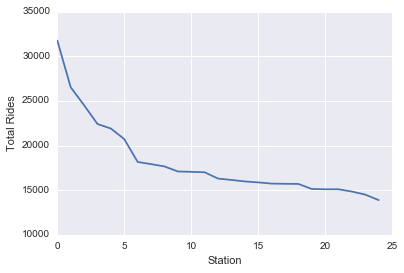

In [32]:
plt.plot(samp.groupby('start station id').size().nlargest(10).values)
plt.xlabel("Station")
plt.ylabel('Total Rides')
plt.title('Number of Rides in 2015 for the top 10 stations')

## Collecting Data for Model:

### Residential Vs Commercial Districts

Since nyc is divided into various types of zoning districts, I'm going to find which district each station lies in to see if it's residential or commercial.

First, I'm going to get official addresses for our stations using geopy as well as convert our lat long coords into shapely geometry points.

In [13]:
# unique lat-long coords
lat_long = samp[~samp[['start station latitude', 'start station longitude']].duplicated()][['start station id','start station name','start station latitude', 'start station longitude']]

from geopy.geocoders import Nominatim
geo = Nominatim()

# Convert lat-long to geopy addresses
# save progress in this dictionary
station_locs = {}

In [ ]:
# geopy needs a string
lat_long['lat_long'] = lat_long['start station latitude'].map(str) +', '+ lat_long['start station longitude'].map(str)

for idx in lat_long.index:
    if lat_long.ix[idx, 'start station id'] in station_locs:
        continue
    station_locs[lat_long.ix[idx, 'start station id']] = geo.reverse(lat_long.ix[idx, 'lat_long']).address

In [5]:
len(station_locs)

459

In [ ]:
with open('station_locs.pkl', 'wb') as f:
    pickle.dump(station_locs, f, 2)

In [4]:
with open('station_locs.pkl', 'rb') as f:
    station_locs = pickle.load(f)

In [6]:
# Move results back to samp data frame

# geopandas is longitude, latitude
samp['lat_long'] = zip(samp['start station longitude'].values, samp['start station latitude'].values)
samp['address'] = samp['start station id'].map(station_locs)
samp['zipcode'] = samp.address.str.findall(r'\d{5}').map(lambda t:t[0] if len(t)>0 else np.nan)
# typo for washington sq park
samp.ix[samp.zipcode.isnull(), 'zipcode'] = 10011


# and convert to shapely geometry points
samp['geo_points'] = samp.lat_long.map(geom.Point)

Aquire zoning dimensions from: https://data.cityofnewyork.us/City-Government/Zoning-GIS-Data-Shapefile/kdig-pewd

In [8]:
zoning_data = gpd.read_file('Zoning GIS Data- Shapefile.geojson')
zoning_data.shape

(15714, 20)

In [9]:
# Now we want to map each bike location to a zone
print samp.shape
print zoning_data.shape

#overlay, zonedist

# this is going to map citibike station ids to zoning index
loc_zone = {}
for i in samp.index:
    if samp.ix[i, 'start station id'] in loc_zone:
        continue
    loc_zone[samp.ix[i, 'start station id']] = zoning_data[(zoning_data.geometry.contains(samp.ix[i, 'geo_points'])) & (~zoning_data.zonedist.isnull())].index
    


samp['zoning_idx'] = samp['start station id'].map(loc_zone)   

# change the type from an index object to an int
samp['zoning_idx'] = samp.zoning_idx.map(lambda i: list(i)[0])

(2491402, 19)
(15714, 20)


Combine the two so we now have a zone type for each bike station

The zone types are 
    - Residential
    - Commercial
    - Manufacturing
    - Park
    - Battery Park (bpc)

In [ ]:
merged = pd.merge(samp, zoning_data[['zonedist']], left_on='zoning_idx', right_index = True)
merged['zone_type'] = merged.zonedist.map(lambda z: z[0] if z != 'PARK' else z)

# make sure zipcode is an integer
merged['zipcode'] = merged.zipcode.astype('int64')

merged.shape

In [26]:
with open('merged.pkl', 'wb') as f:
    pickle.dump(merged,f,2)

In [10]:
with open('merged.pkl', 'rb') as f:
    merged = pickle.load(f)
    
merged.shape

(2491402, 22)

### Population By Community District

Population is available on the Community District level from Nyc Open Data

In [36]:
# Geographical data for all the community districts, so we know where each district actually is.
cds = gpd.read_file("Community Districts.geojson")
cds.shape

(71, 4)

In [37]:
# Populations for each district
pops = pd.read_csv('New_York_City_Population_By_Community_Districts.csv')

boro_map = {'Manhattan':'1', 'Bronx':'2',  'Brooklyn':'3', 'Queens':'4', "Staten Island":'5'}
pops['CD_ID'] = pops.Borough.map(boro_map) + pops['CD Number'].astype(str).str.zfill(2)

In [38]:
# Add Community Districts to our dataframe so that we can merge with populations
stn_cd = {}

In [39]:
for i in merged.drop_duplicates('start station id').index:
    if merged.ix[i, 'start station id'] in stn_cd:
        continue
    stn_cd[merged.ix[i, 'start station id']] = cds[cds.geometry.contains(merged.ix[i, 'geo_points'])].boro_cd.values[0]

In [40]:
merged['CD'] = merged['start station id'].map(stn_cd)
merged.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,...,birth year,gender,lat_long,address,zipcode,geo_points,zoning_idx,zonedist,zone_type,CD
0,1346,2015-01-01 00:01:00,2015-01-01 00:24:00,455,1 Ave & E 44 St,40.750020,-73.969053,265,Stanton St & Chrystie St,40.722293,...,1960.0,2,"(-73.96905301, 40.75001986)","Citi Bike - 1 Ave & E 44 St, 1st Avenue Tunnel...",10017,POINT (-73.96905301 40.75001986),14720,C5-2,C,106
369,133,2015-01-01 02:42:00,2015-01-01 02:44:00,2017,E 43 St & 2 Ave,40.750224,-73.971214,518,E 39 St & 2 Ave,40.747804,...,1984.0,1,"(-73.97121414, 40.75022392)","Citi Bike - E 43 St & 2 Ave, East 43rd Street,...",10017,POINT (-73.97121414 40.75022392),14720,C5-2,C,106
447,1198,2015-01-01 03:15:00,2015-01-01 03:35:00,2017,E 43 St & 2 Ave,40.750224,-73.971214,342,Columbia St & Rivington St,40.717400,...,1983.0,2,"(-73.97121414, 40.75022392)","Citi Bike - E 43 St & 2 Ave, East 43rd Street,...",10017,POINT (-73.97121414 40.75022392),14720,C5-2,C,106
591,474,2015-01-01 06:53:00,2015-01-01 07:01:00,2017,E 43 St & 2 Ave,40.750224,-73.971214,164,E 47 St & 2 Ave,40.753231,...,1954.0,1,"(-73.97121414, 40.75022392)","Citi Bike - E 43 St & 2 Ave, East 43rd Street,...",10017,POINT (-73.97121414 40.75022392),14720,C5-2,C,106
990,976,2015-01-01 10:45:00,2015-01-01 11:01:00,2017,E 43 St & 2 Ave,40.750224,-73.971214,402,Broadway & E 22 St,40.740343,...,1959.0,1,"(-73.97121414, 40.75022392)","Citi Bike - E 43 St & 2 Ave, East 43rd Street,...",10017,POINT (-73.97121414 40.75022392),14720,C5-2,C,106


District 164 represents central park, which does not have a given population statistic. Therefore i'm going to reasign the stations that fall within this district to their nearest community district with a given population

In [41]:
# For stations on CPW i'm going to assign the population data for District 107 
# which corresponds to the west side between 59th st and 110th
merged.loc[merged['start station name'].isin(['Central Park West & W 68 St',
                           'Central Park West & W 76 St', 'Central Park West & W 72 St']), 'CD'] = '107'


# The two stations on the east side are nearest to CD 108 which extends from ~ 59th - 86th st on the east side
merged.loc[merged['start station name'].isin(['5 Ave & E 63 St', '5 Ave & E 73 St']), 'CD'] = '108'


# CPS and 6th ave is nearest to district 105
merged.loc[merged['start station name'] == 'Central Park S & 6 Ave', 'CD'] = '105'

In [42]:
print merged.shape
print pops.shape

merged1 = pd.merge(merged, pops, left_on='CD', right_on = 'CD_ID')
print merged1.shape

(2491402, 23)
(59, 9)
(2491402, 32)


### Demographics by Zipcode

Lets include some ethnicity and gender demographics for the corresponding zipcode to each bike staiton.

In [43]:
demographics = pd.read_csv('Zip_code_breakdowns.csv', usecols=['JURISDICTION NAME','COUNT PARTICIPANTS','PERCENT FEMALE', 'PERCENT MALE','PERCENT PACIFIC ISLANDER','PERCENT HISPANIC LATINO', 'PERCENT AMERICAN INDIAN',
'PERCENT ASIAN NON HISPANIC','PERCENT WHITE NON HISPANIC', 'PERCENT BLACK NON HISPANIC', 'PERCENT OTHER ETHNICITY'])
demographics.shape

(236, 11)

In [44]:
merged2 = pd.merge(merged1, demographics, left_on='zipcode', right_on='JURISDICTION NAME', how = 'left')
merged2.shape

(2491402, 43)

In [45]:
merged2.isnull().sum()

tripduration                       0
starttime                          0
stoptime                           0
start station id                   0
start station name                 0
start station latitude             0
start station longitude            0
end station id                     0
end station name                   0
end station latitude               0
end station longitude              0
bikeid                             0
usertype                           0
birth year                    353859
gender                             0
lat_long                           0
address                            0
zipcode                            0
geo_points                         0
zoning_idx                         0
zonedist                           0
zone_type                          0
CD                                 0
Borough                            0
CD Number                          0
CD Name                            0
1970 Population                    0
1

Lots of missing values.

Additionally, some of the demographic surveys have 0 participants and hence all the values are therefore 0. We will treat those as missing values

In [46]:
# FILL NAs 
merged2.fillna({'COUNT PARTICIPANTS': 0}, inplace = True)

# Fill with mean for our features of interest
null_cols = ['PERCENT FEMALE','PERCENT MALE','PERCENT PACIFIC ISLANDER','PERCENT HISPANIC LATINO',
'PERCENT AMERICAN INDIAN', 'PERCENT ASIAN NON HISPANIC','PERCENT WHITE NON HISPANIC','PERCENT BLACK NON HISPANIC',
'PERCENT OTHER ETHNICITY']

merged2.loc[:,null_cols] = merged2[null_cols].fillna(merged2[null_cols].mean())

# Rows where the number of participants is 0. Replace them with the mean as well
merged2.loc[merged2['COUNT PARTICIPANTS'] == 0, null_cols] =  merged2.ix[merged2['COUNT PARTICIPANTS'] == 0, null_cols].apply(lambda c: c.replace(0,np.nan)).fillna(merged2[null_cols].mean())




Parse the datetime feature into season, day of the week, and date (without time)

In [47]:
s = zip(range(1,13),['winter','winter']+['spring']*3 + ['summer']*3 + ['fall'] *3 + ['winter'])
seasons = dict(s)


dow = dict(zip(range(7), ['monday','tuesday','wednesday','thursday','friday','saturday','sunday']))

merged2['season'] = merged2.starttime.dt.month.map(seasons)
merged2['dow'] = merged2.starttime.dt.dayofweek.map(dow)
merged2['date'] = merged2.starttime.dt.date

### Weather Data

Collected historical weather data from https://www.wunderground.com/

In [48]:
weather = []
with open('get_weather_data/historicalWeather.jl', 'r') as f:
    for line in f:
        weather.append(json.loads(line))
        
# hmmm we have 7 extra days...      
len(weather)

372

In [49]:
weather = pd.DataFrame(weather)
# change data to numbers
weather.iloc[:,1:] = weather.iloc[:,1:].apply(lambda c: pd.to_numeric(c, errors='coerce'))


def reorder_date(d):
    y,m,d = d.split('/')
    return '/'.join([m,d,y])
# parse dates
weather['date'] = pd.to_datetime(weather.date.map(reorder_date), errors = 'coerce')

print weather.isnull().sum()


date             7
dew_point        0
max_temp         0
mean_temp        0
min_temp         0
month_precip    11
month_snow       7
precip          22
snow            14
wind_speed       2
dtype: int64


In [50]:
weather = weather[[u'date', u'dew_point', u'max_temp',
 u'mean_temp', u'min_temp',u'precip', u'month_precip',
 u'snow', u'month_snow', u'wind_speed']]

In [51]:
# drop not real dates eg 2/30
weather.drop(weather[weather.date.isnull()].index, inplace = True)
weather.reset_index(inplace=True)
weather.shape # HOORAY

(365, 11)

#### Fill NAs

In [52]:
# all the month precip nulls are in one week in may when it did not rain. So filling with 0s
weather.fillna({'month_precip':0}, inplace = True)

# Month Snow nulls are in first week of January when it did not snow and end of December where there was no snow
# so filling with zeros
weather.fillna({'month_snow':0, 'snow':0}, inplace = True)

# Filling wind speed with the median value
print weather.wind_speed.median()
weather.fillna({'wind_speed': weather.wind_speed.median()}, inplace = True)
weather.isnull().sum()


#checked by hand, all the precip nulls are 0
weather.fillna({'precip':0}, inplace = True)

weather.isnull().sum()

5.0


index           0
date            0
dew_point       0
max_temp        0
mean_temp       0
min_temp        0
precip          0
month_precip    0
snow            0
month_snow      0
wind_speed      0
dtype: int64

Join the Weather Data to the rest

In [53]:
print weather.shape
print merged2.shape
merged3 = pd.merge(weather, merged2, left_on = weather.date.dt.date, right_on = 'date')
merged3.shape

(365, 11)
(2491402, 46)


(2491402, 57)

In [54]:
merged3.drop(['index','date_x'], inplace = True, axis = 1)

In [55]:
merged3.columns = [u'dew_point', u'max_temp',
u'mean_temp', u'min_temp',
u'precip', u'month_precip',
u'snow', u'month_snow',
u'wind_speed', u'tripduration',
u'starttime', u'stoptime',
u'start station id', u'start station name',
u'start station latitude', u'start station longitude',
u'end station id', u'end station name',
u'end station latitude', u'end station longitude',
u'bikeid', u'usertype',
u'birth year', u'gender',
u'lat_long', u'address',
u'zipcode', u'geo_points',
u'zoning_idx', u'zonedist',
u'zone_type', u'CD',
u'Borough', u'CD Number',
u'CD Name', u'1970 Population',
u'1980 Population', u'1990 Population',
u'2000 Population', u'2010 Population',
u'CD_ID', u'JURISDICTION NAME',
u'COUNT PARTICIPANTS', u'PERCENT FEMALE',
u'PERCENT MALE', u'PERCENT PACIFIC ISLANDER',
u'PERCENT HISPANIC LATINO', u'PERCENT AMERICAN INDIAN',
'PERCENT ASIAN NON HISPANIC', u'PERCENT WHITE NON HISPANIC',
'PERCENT BLACK NON HISPANIC', u'PERCENT OTHER ETHNICITY',
u'season', u'dow',
u'date']

Lastly I want to make sure that each station is represented by it's usage. Creating 450+ dummy variables for each of the stations would be too much, so instead I'm going to just create 2 new columns. One that represents the mean daily usage of the given station, the other just an indicator of whether or not that station is one of the top 6 most used stations.

One thing to consider is how to calculate those 2 columns. Here I'm using the same data to calculate the mean usage and largest stations - but in practice I'd want to use the data from the same month the year prior.

In [103]:
usg = merged3.groupby(['date', 'start station id']).size().reset_index()
usg.columns = ['date','station','usg']
station_usg = usg.groupby('station').usg.mean()
station_usg.head()

station
72      76.945652
79      64.197802
82      27.228261
83      29.989130
116    132.189873
Name: usg, dtype: float64

Now we need to move the data into a format so that we can feed it into a model.

We are going to be predicting the ridership at a given station for a given day based off of 
    - demographics of the population living in the same zip code or district as the station
    - what type of zoning district the station is in
    - the day of the week
    - the season

In [104]:
data = merged3
data.dtypes

dew_point                             object
max_temp                              object
mean_temp                             object
min_temp                              object
precip                               float64
month_precip                         float64
snow                                 float64
month_snow                           float64
wind_speed                           float64
tripduration                           int64
starttime                     datetime64[ns]
stoptime                      datetime64[ns]
start station id                       int64
start station name                    object
start station latitude               float64
start station longitude              float64
end station id                         int64
end station name                      object
end station latitude                 float64
end station longitude                float64
bikeid                                 int64
usertype                              object
birth year

In [105]:
data[['dew_point','max_temp','mean_temp','min_temp']] = data[['dew_point','max_temp','mean_temp','min_temp']].astype('int64')

In [169]:
top6 = station_usg.sort_values(ascending=False)[:6].index.tolist()
top6 = {s: top6.index(s) for s in top6}
top6

{293: 2, 426: 5, 435: 3, 497: 4, 519: 1, 521: 0}

In [198]:
Y = data.groupby(['date','start station id']).size()
print Y.shape

X = data.sort_values(['date','start station id']).drop_duplicates(['date','start station id'])
X['station_mean_usg'] = X['start station id'].map(station_usg)
X['busy_stn'] = 0
X.loc[X['start station id'].isin(station_usg.sort_values(ascending = False)[:6].index), 'busy_stn'] = 1
#X.loc[X['busy_stn'] == 1, 'busy_stn'] = X.loc[X['busy_stn'] == 1, 'start station id'].map(top6)
print X.shape



# season, day of the week, zone type, borough, and CD are categorical and need to be 1-hot encoded
season_col = pd.get_dummies(X.season)
season_col['summer'] = 0 
dow_col = pd.get_dummies(X.dow)
zonetype_col = pd.get_dummies(X.zone_type)
borough_col = pd.get_dummies(X.Borough)

print season_col.shape
print dow_col.shape
print zonetype_col.shape
print borough_col.shape

(32792,)
(32792, 57)
(32792, 4)
(32792, 7)
(32792, 5)
(32792, 3)


In [188]:
with open('XY.pkl','wb') as f:
    pickle.dump((X,Y), f, 2)
    

In [131]:
with open('XY.pkl','rb') as f:
    X, Y = pickle.load(f)

In [199]:
ftr_cols = ['dew_point', u'max_temp', u'mean_temp', u'min_temp', u'precip',
       u'month_precip', u'snow', u'month_snow', u'wind_speed',
       u'PERCENT FEMALE', u'PERCENT MALE', u'PERCENT PACIFIC ISLANDER',
       u'PERCENT HISPANIC LATINO', u'PERCENT AMERICAN INDIAN',
       u'PERCENT ASIAN NON HISPANIC', u'PERCENT WHITE NON HISPANIC',
       u'PERCENT BLACK NON HISPANIC', u'PERCENT OTHER ETHNICITY', 
      '2000 Population', '2010 Population', 'station_mean_usg','busy_stn']
x = pd.merge(X[ftr_cols], season_col, 
             left_index=True, right_index = True).merge(dow_col, 
                                left_index=True, right_index = True).merge(zonetype_col, 
                                    left_index=True, right_index = True).merge(borough_col, left_index = True,
                                                    right_index=True).reset_index()
y = Y.reset_index(drop=True)
print x.shape, y.shape
x.head()

(32792, 42) (32792,)


,index,dew_point,max_temp,mean_temp,min_temp,precip,month_precip,snow,month_snow,wind_speed,PERCENT FEMALE,PERCENT MALE,PERCENT PACIFIC ISLANDER,PERCENT HISPANIC LATINO,PERCENT AMERICAN INDIAN,PERCENT ASIAN NON HISPANIC,PERCENT WHITE NON HISPANIC,PERCENT BLACK NON HISPANIC,PERCENT OTHER ETHNICITY,2000 Population,2010 Population,station_mean_usg,busy_stn,fall,spring,winter,summer,friday,monday,saturday,sunday,thursday,tuesday,wednesday,B,C,M,PARK,R,Brooklyn,Manhattan,Queens
0,1935852,10,39,33,27,0.0,0.0,0.0,0.0,7.0,0.397814,0.249522,0.0,0.087878,0.0,0.343625,0.042399,0.128165,0.042431,87479,103245,76.945652,0,0.0,0.0,1.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,1939310,10,39,33,27,0.0,0.0,0.0,0.0,7.0,0.130000,0.880000,0.0,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,34420,60978,64.197802,0,0.0,0.0,1.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1938149,10,39,33,27,0.0,0.0,0.0,0.0,7.0,0.690000,0.310000,0.0,0.130000,0.0,0.560000,0.000000,0.310000,0.000000,164407,163277,27.228261,0,0.0,0.0,1.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,1936991,10,39,33,27,0.0,0.0,0.0,0.0,7.0,0.397814,0.249522,0.0,0.087878,0.0,0.343625,0.042399,0.128165,0.042431,98620,99617,29.989130,0,0.0,0.0,1.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1935677,10,39,33,27,0.0,0.0,0.0,0.0,7.0,0.670000,0.330000,0.0,0.330000,0.0,0.000000,0.000000,0.330000,0.330000,87479,103245,132.189873,0,0.0,0.0,1.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [200]:
x['Pop_Growth'] = (x['2010 Population'] - x['2000 Population'])/x['2000 Population']



In [201]:
x= x.drop(['PERCENT PACIFIC ISLANDER', 'PERCENT AMERICAN INDIAN'], axis = 1)

In [202]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

In [203]:
x_train, x_test, y_train, y_test = train_test_split(x.ix[:,1:],y)

In [204]:
lreg = LinearRegression(n_jobs = -1, normalize=True)
l1 = Lasso(alpha = 0.0005, normalize=True)
lreg.fit(x_train, np.log(y_train))
l1.fit(x_train, np.log(y_train))

preds = lreg.predict(x_test)
print "LREG:", np.sqrt(metrics.mean_squared_error(np.log(y_test), preds))

preds2 = l1.predict(x_test)
print "L1:", np.sqrt(metrics.mean_squared_error(np.log(y_test), preds2))

LREG: 0.541705961683
L1: 0.603488180215


In [205]:
rfor = RandomForestRegressor(n_estimators=100, max_features = 'sqrt', max_depth = 10)
rfor.fit(x_train,np.log(y_train))
etree = ExtraTreesRegressor(n_estimators=150, max_depth=10, bootstrap=True)
etree.fit(x_train, np.log(y_train))

preds = rfor.predict(x_test)
print np.sqrt(metrics.mean_squared_error(np.log(y_test), preds))

preds2 = etree.predict(x_test)
print np.sqrt(metrics.mean_squared_error(np.log(y_test), preds2))

print np.sqrt(metrics.mean_squared_error(y_test, np.exp(preds2)))

0.431493757269
0.397453580389
24.8411981588


In [186]:
import xgboost

xg = xgboost.XGBRegressor(objective='count:poisson',learning_rate=0.08, max_depth = 15)
xg.fit(x_train, np.log(y_train))

preds = xg.predict(x_test)
print np.sqrt(metrics.mean_squared_error(np.log(y_test), preds))
np.sqrt(metrics.mean_squared_error(y_test, np.exp(preds)))

0.360600664098


19.885858371345655

In [206]:
sorted(zip(x_test.columns, lreg.coef_), key = lambda x: abs(x[1]), reverse = True)[:25]

sorted(zip(x_test.columns, etree.feature_importances_), key = lambda x: abs(x[1]), reverse = True)[:33]


[('winter', 0.34513264538814731),
 ('station_mean_usg', 0.2662237915413363),
 ('Manhattan', 0.25596463051575108),
 (u'precip', 0.026274100657352056),
 (u'snow', 0.014981652310745233),
 ('saturday', 0.013305483963400777),
 ('busy_stn', 0.0063494617662848592),
 ('sunday', 0.0062669189690188502),
 (u'month_precip', 0.0061872029391538035),
 ('Pop_Growth', 0.0055163104224324492),
 (u'2010 Population', 0.0052798193406238926),
 ('tuesday', 0.0052372410136383206),
 (u'month_snow', 0.0051420806959690717),
 (u'2000 Population', 0.0044609263003065319),
 ('Brooklyn', 0.0035385516309032593),
 (u'dew_point', 0.0031839592593135933),
 (u'C', 0.0023633578750603553),
 (u'min_temp', 0.002182338482096854),
 (u'mean_temp', 0.0019984840468888821),
 (u'M', 0.0018687452837894177),
 (u'PERCENT HISPANIC LATINO', 0.0017552228057356137),
 (u'R', 0.0016523191089497279),
 (u'max_temp', 0.0014777726730924126),
 (u'PERCENT MALE', 0.0013055987261862676),
 (u'PERCENT OTHER ETHNICITY', 0.0012661070059701001),
 ('PERCENT

In [207]:
x = x.drop(x.columns[~x.columns.isin(['winter', 'Manhattan', u'precip', 'Pop_Growth', u'2010 Population', u'2000 Population', 'saturday', 
u'snow', u'C', 'Brooklyn', 'sunday', u'month_precip', u'PERCENT HISPANIC LATINO', u'PERCENT FEMALE', 
u'PERCENT MALE', u'R', u'month_snow', u'M', 'PERCENT ASIAN NON HISPANIC', 'tuesday', u'PARK', 
u'PERCENT WHITE NON HISPANIC', u'PERCENT OTHER ETHNICITY', u'dew_point', 'PERCENT BLACK NON HISPANIC', 'station_mean_usg','busy_stn'])], axis =1)


In [208]:
# same performance, less features
x_train, x_test, y_train, y_test = train_test_split(x,y)

etree = ExtraTreesRegressor(n_estimators=100, max_depth=10, bootstrap=False)
etree.fit(x_train, np.log(y_train))

preds2 = etree.predict(x_test)
print np.sqrt(metrics.mean_squared_error(np.log(y_test), preds2))

print np.sqrt(metrics.mean_squared_error(y_test, np.exp(preds2)))

0.395449723291
26.0609830358


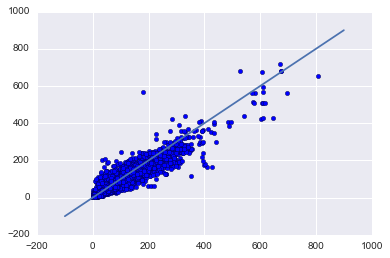

In [209]:
plt.scatter(y_test, np.exp(preds2))
plt.plot(plt.xlim(), plt.xlim())